In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_investorsbusinessdaily_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,0,1.015779e+16,2021-05-31 17:24:31.968425,Trade like the pro's and don't miss this speci...,3,0,0.000,0.000,8.000,0.000,...,15,0.200000,0,0,15,0.0,0.302,0.000,0.698,0.7477
1,1,1.015779e+16,2021-05-31 17:24:33.154690,IBD’s #MemorialDay sale is here! Now’s your ch...,9,0,0.625,0.000,10.375,0.625,...,16,0.000000,0,0,16,0.0,0.217,0.000,0.783,0.7494
2,2,1.015779e+16,2021-05-30 23:24:36.751058,IBD’s #MemorialDay sale is here! Now’s your ch...,11,1,0.625,0.000,10.375,0.625,...,16,0.000000,0,0,16,0.0,0.217,0.000,0.783,0.7494
3,3,1.015779e+16,2021-05-30 16:57:00,IBD’s #MemorialDay sale is here! Now’s your ch...,14,0,0.625,0.000,10.375,0.625,...,16,0.000000,0,0,16,0.0,0.217,0.000,0.783,0.7494
4,4,1.015778e+16,2021-05-30 15:16:00,"Work smarter, not harder. Working Smart Lets...",67,3,0.000,1.125,3.875,-1.125,...,6,-0.333333,0,0,6,0.0,0.174,0.131,0.695,0.1882


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

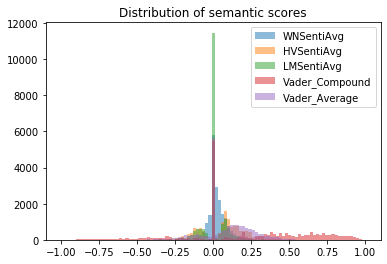

In [6]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

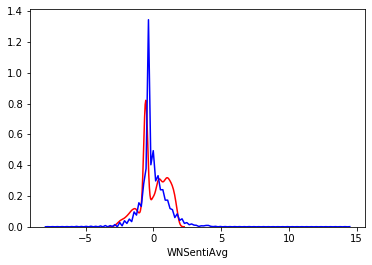

In [7]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [8]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,19131.000000,19131.000000,19131.000000,19131.000000,19131.000000
mean,0.023240,0.047031,0.002380,0.233178,0.084255
std,0.059895,0.134950,0.073283,0.412082,0.161599
min,-0.437500,-0.750000,-0.666667,-0.965700,-0.624000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.012500,0.000000,0.000000,0.202300,0.065000
75%,0.050000,0.125000,0.000000,0.585900,0.194000
max,0.875000,1.000000,1.000000,0.989100,0.800000


In [9]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [10]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [11]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [12]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [13]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [14]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [15]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -10.8729
p-value                           0.0000
#Lags Used                       13.0000
Number of Observations Used    3660.0000
Critical Value (1%)              -3.4321
Critical Value (5%)              -2.8623
Critical Value (10%)             -2.5672
dtype: float64


In [16]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -9.9495
p-value                           0.0000
#Lags Used                       16.0000
Number of Observations Used    3657.0000
Critical Value (1%)              -3.4321
Critical Value (5%)              -2.8623
Critical Value (10%)             -2.5672
dtype: float64


In [17]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -9.9495
p-value                           0.0000
#Lags Used                       16.0000
Number of Observations Used    3657.0000
Critical Value (1%)              -3.4321
Critical Value (5%)              -2.8623
Critical Value (10%)             -2.5672
dtype: float64
Results of Dickey-Fuller Test:


In [18]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -13.4109
p-value                           0.0000
#Lags Used                       10.0000
Number of Observations Used    3663.0000
Critical Value (1%)              -3.4321
Critical Value (5%)              -2.8623
Critical Value (10%)             -2.5672
dtype: float64
Results of Dickey-Fuller Test:


In [19]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2009-03-14,0.000000,2,0.361450,0.179000,0,2,29,0,2,29,0.000000,-0.068966,-0.068966
2009-03-17,0.039141,3,0.132467,0.048333,0,4,46,0,2,46,0.013047,-0.086957,-0.043478
2009-03-18,0.166667,2,0.334800,0.189500,1,2,28,0,2,28,0.083333,-0.035714,-0.071429
2009-03-19,0.064732,2,0.255300,0.095500,2,4,29,0,2,29,0.032366,-0.068966,-0.068966
2009-03-20,-0.073413,2,-0.285350,-0.132500,2,2,29,1,2,29,-0.036706,0.000000,-0.034483


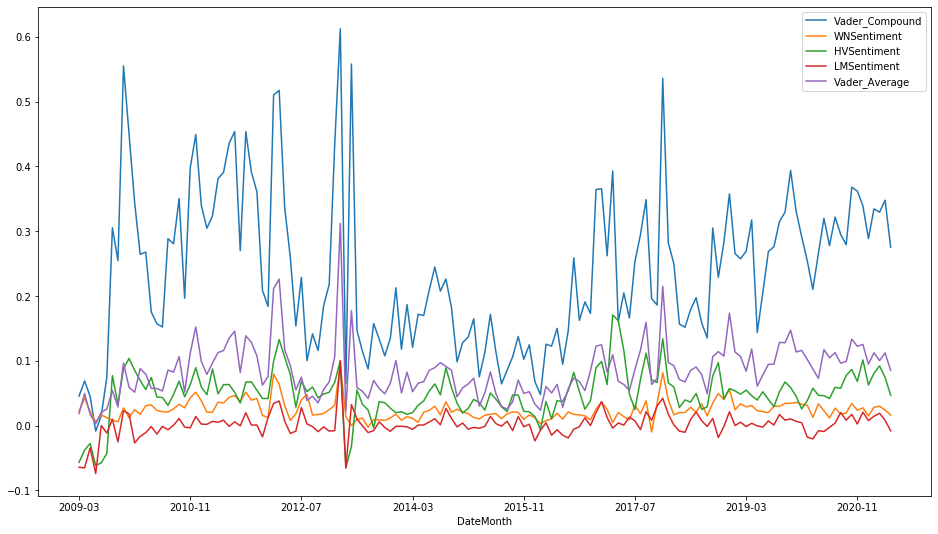

In [20]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [21]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [22]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [23]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [24]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [25]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [26]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [27]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [28]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [29]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2010-10,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010,NaN,2.864736,105,0.196482,0.051619,191,116,1689,30,34,1689,0.027283,0.044405,-0.002368
2010-11,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049,-0.002293,4.947423,116,0.397666,0.111819,201,94,1704,32,38,1704,0.042650,0.062793,-0.003521
2010-12,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015,0.063256,6.085497,118,0.449190,0.152186,237,84,1711,53,29,1711,0.051572,0.089421,0.014027
2011-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995,0.022393,6.425749,168,0.339728,0.098887,315,157,2662,65,59,2662,0.038249,0.059354,0.002254
2011-02,1344.069946,1289.140015,1289.140015,1327.219971,59223660000,1327.219971,0.031457,3.143643,153,0.304565,0.079007,286,160,2640,65,60,2640,0.020547,0.047727,0.001894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,2.782006,188,0.288806,0.094846,354,191,2603,66,46,2603,0.014798,0.062620,0.007683
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,5.561367,198,0.334448,0.112379,435,205,2850,97,56,2850,0.028088,0.080702,0.014386
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,7.208230,241,0.329398,0.100290,572,242,3581,124,56,3581,0.029910,0.092153,0.018989
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,4.812882,202,0.347788,0.112213,396,187,2821,80,57,2821,0.023826,0.074087,0.008153


In [31]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var][1:], Granger_data_daily['LogReturn'][1:])


Vader_Compound

Optimal number of lags for exog data is 10
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5551  , p=0.4563  , df_denom=2364, df_num=1
ssr based chi2 test:   chi2=0.5558  , p=0.4560  , df=1
likelihood ratio test: chi2=0.5557  , p=0.4560  , df=1
parameter F test:         F=0.5551  , p=0.4563  , df_denom=2364, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5535  , p=0.5750  , df_denom=2361, df_num=2
ssr based chi2 test:   chi2=1.1093  , p=0.5743  , df=2
likelihood ratio test: chi2=1.1090  , p=0.5743  , df=2
parameter F test:         F=0.5535  , p=0.5750  , df_denom=2361, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4351  , p=0.7279  , df_denom=2358, df_num=3
ssr based chi2 test:   chi2=1.3092  , p=0.7270  , df=3
likelihood ratio test: chi2=1.3088  , p=0.7270  , df=3
parameter F t

Optimal number of lags for exog data is 6
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5223  , p=0.4699  , df_denom=2364, df_num=1
ssr based chi2 test:   chi2=0.5229  , p=0.4696  , df=1
likelihood ratio test: chi2=0.5229  , p=0.4696  , df=1
parameter F test:         F=0.5223  , p=0.4699  , df_denom=2364, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3228  , p=0.7242  , df_denom=2361, df_num=2
ssr based chi2 test:   chi2=0.6470  , p=0.7236  , df=2
likelihood ratio test: chi2=0.6469  , p=0.7237  , df=2
parameter F test:         F=0.3228  , p=0.7242  , df_denom=2361, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3906  , p=0.7598  , df_denom=2358, df_num=3
ssr based chi2 test:   chi2=1.1752  , p=0.7589  , df=3
likelihood ratio test: chi2=1.1750  , p=0.7590  , df=3
parameter F test:         F=0.3

Optimal number of lags for exog data is 5
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0093  , p=0.9231  , df_denom=2364, df_num=1
ssr based chi2 test:   chi2=0.0093  , p=0.9231  , df=1
likelihood ratio test: chi2=0.0093  , p=0.9231  , df=1
parameter F test:         F=0.0093  , p=0.9231  , df_denom=2364, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7745  , p=0.4611  , df_denom=2361, df_num=2
ssr based chi2 test:   chi2=1.5522  , p=0.4602  , df=2
likelihood ratio test: chi2=1.5517  , p=0.4603  , df=2
parameter F test:         F=0.7745  , p=0.4611  , df_denom=2361, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3000  , p=0.2727  , df_denom=2358, df_num=3
ssr based chi2 test:   chi2=3.9117  , p=0.2712  , df=3
likelihood ratio test: chi2=3.9085  , p=0.2715  , df=3
parameter F test:         F=1.3

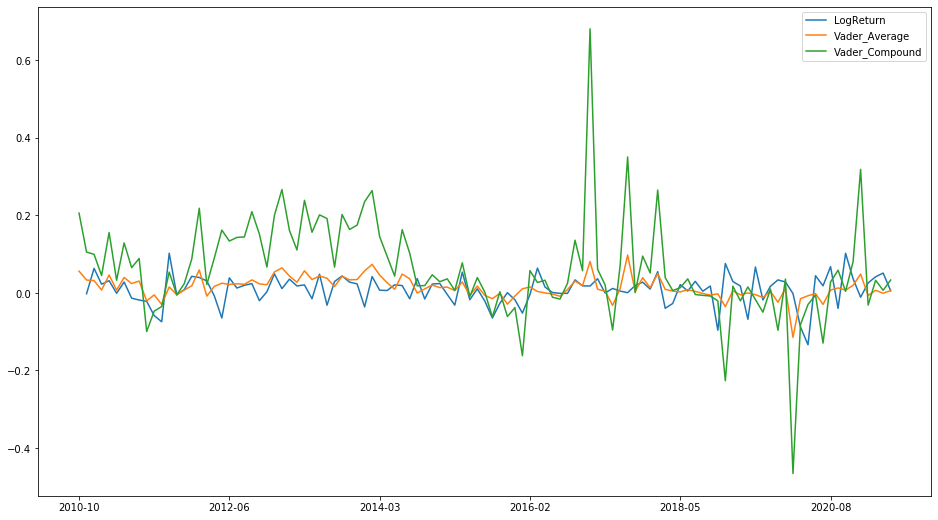

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [33]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment", 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.923797,0.446240,0.412146,0.469954,0.065604
Vader_Average,0.923797,1.000000,0.419069,0.383257,0.480702,0.054010
WNSentiment,0.446240,0.419069,1.000000,0.290907,0.306443,0.035240
HVSentiment,0.412146,0.383257,0.290907,1.000000,0.440085,0.048366
LMSentiment,0.469954,0.480702,0.306443,0.440085,1.000000,0.040736
LogReturn,0.065604,0.054010,0.035240,0.048366,0.040736,1.000000


In [32]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.001402
Vader_Average   0.008569
WNSentiment     0.086444
HVSentiment     0.018586
LMSentiment     0.047471


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
